In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
class Synapse:
    
    def __init__(self,population,s_id,params):
        
        print('synapse:',params)
        
        self.s = s_id
        self.tau_n = params['tau_n']
        self.tau_I = params['tau_I']          # synaptic timeconstant in s

In [3]:
class Population:

    def __init__(self,layer,p_id,params):
        
        print('population:',params)

        self.p = p_id
        self.layer = layer

        self.rateWnt = params['rateWnt']
        self.q = np.NaN

        self.alpha_0 = params['alpha_0']
        self.J = np.zeros((layer.nPop,1))

        self.nPSP = params['nPSP']
        self.psp = []
        for s in range(self.nPSP):
            handover_params = {}
            for key,val in params.items():
                if type(val)==list and len(val)==self.nPSP:
                    handover_params[key] = val[s]
            self.psp.append(Synapse(self,s,handover_params))
    
    
    def I_squared_nu(self):
        return - ( self.alpha**2 + self.sigma_V**2 ) * np.log( (self.rateWnt/self.rate_max)**2 * (1 + (self.alpha / self.sigma_V)**2) )
    
    def I_squared_q(self):
        return -( self.alpha**2 + 1./2 * self.sigma_V**2 ) * np.log( ( self.q/self.rate_max**2 )**2 * (1 + 2*(self.alpha / self.sigma_V)**2) )
    
    

In [4]:
class Layer:
        
    def __init__(self,network,l_id,params):
        
        print('layer:',params)

        self.l = l_id
        self.network = network
        
        self.eta = params['eta']
        self.eps = params['eps']
        self.J0 = params['J0'] * network.tau_m    # synaptic coupling strength
        self.J_l = params['J_l'] * network.tau_m
        self.kappa = params['kappa']

        self.nPop = 2#params['nPop']
        self.pop = []
        
        for p in range(self.nPop):
            handover_params = {}
            for key,val in params.items():
                if type(val)==list and len(val)==self.nPop:
                    handover_params[key] = val[p]
            self.pop.append(Population(self,p,handover_params))
        
        self.setWeights()
        
    
    
    def setWeights(self):

        self.pop[0].J[0] = self.J0 * np.sqrt(1 - self.eps**2)
        self.pop[0].J[1] = self.J0 * np.sqrt(1 - (self.eta*self.eps)**2)
        self.pop[1].J[0] = self.J0 * self.eps
        self.pop[1].J[1] = self.J0 * self.eta*self.eps
    

In [5]:
class Network:

    def __init__(self,**params):
        
        print('network:',params)
        
        self.tau_m = params['tau_m']          # membrane timeconstant in s
        
        self.nLayer = params['nLayer']
        
        self.layer = []
        for l in range(self.nLayer):
            handover_params = {}
            for key,val in params.items():
                if type(val)==list and len(val)==self.nLayer:
                    handover_params[key] = val[l]
            self.layer.append(Layer(self,l,handover_params))
            
    
    def setSigma(self):
        
        for l in range(self.nLayer):
            
            for p in range(self.layer[l].nPop):    ## receiving population
                
                var_V = 0
                var_V_dot = 0
                
                for ll in range(self.nLayer):
                    
                    for pp in range(self.layer[ll].nPop):    ## projecting population
                        
                        J = self.layer[ll].pop[pp].J[p] if (l==ll) else self.layer[ll].J_l[l]

                        for s in range(self.layer[ll].pop[pp].nPSP):
                            ## calculate the prefactor, common to all cases
                            prefactor = J**2 * self.layer[ll].pop[pp].rateWnt / \
                                (self.layer[ll].pop[pp].psp[s].tau_I + self.tau_m)

                            if self.layer[ll].pop[pp].nPSP==1:
                                tmp_var_V = prefactor / 2.
                            else:
                                ## calculates the mix term of 2 different receptor types
                                tmp_var_V = prefactor * (self.layer[ll].pop[pp].psp[s].tau_n**2/2 + \
                                    (1-self.layer[ll].pop[pp].psp[s].tau_n) * self.layer[ll].pop[pp].psp[s].tau_n * self.layer[ll].pop[pp].psp[s].tau_I / \
                                    (self.layer[ll].pop[pp].psp[0].tau_I + self.layer[ll].pop[pp].psp[1].tau_I) );

                            var_V += tmp_var_V;
                            var_V_dot += tmp_var_V/(self.layer[ll].pop[pp].psp[s].tau_I * self.tau_m);

                self.layer[l].pop[p].sigma_V = np.sqrt(var_V)
                self.layer[l].pop[p].sigma_V_dot = np.sqrt(var_V_dot)

                self.layer[l].pop[p].rate_max = np.sqrt(var_V_dot / var_V) / (2 * math.pi);
                
                #print('sigma',self.layer[l].pop[p].sigma_V)
                print('rate max:',self.layer[l].pop[p].rate_max)
                
    
    
    def setAlpha(self):
        
        for l in range(self.nLayer):
            
            for p in range(self.layer[l].nPop):    ## receiving population
            
                alpha_sq = 0

                for ll in range(self.nLayer):

                    for pp in range(self.layer[ll].nPop):

                        J = self.layer[ll].pop[pp].J[p] if (l==ll) else self.layer[ll].J_l[l]

                        tmp_alpha_sq = J**2 * self.layer[ll].pop[pp].q
                        if pp==0:
                            tmp_alpha_sq *= self.layer[ll].kappa;

                        alpha_sq += tmp_alpha_sq;

                
                self.layer[l].pop[p].alpha = np.sqrt( alpha_sq + self.layer[l].pop[p].alpha_0**2)
                
                #print('alpha:',self.layer[l].pop[p].alpha)
            
    
    def get_solution(self):
        
        self.setSigma()
        
        q = np.zeros((self.nLayer*2,))
        i = 0
        for l in range(self.nLayer):
            for p in range(self.layer[l].nPop):
                q[i] = self.layer[l].pop[p].rateWnt**2
                i+=1
        
        q_exact = fsolve(self.find_q,q)
        
        #print(q_exact)
        i = 0
        for l in range(self.nLayer):
            for p in range(self.layer[l].nPop):
                self.layer[l].pop[p].q = q_exact[i]
                i += 1
        
        self.setAlpha()

        
    def find_q(self,q):
        
        # set q
        i = 0
        for l in range(self.nLayer):
            for p in range(self.layer[l].nPop):
                self.layer[l].pop[p].q = q[i]
                i += 1
        
        # calculate alpha
        self.setAlpha()
        
        dI = np.zeros((i,))
        
        # calculate dI
        
        i = 0
        for l in range(self.nLayer):
            for p in range(self.layer[l].nPop):
                dI[i] = self.layer[l].pop[p].I_squared_nu() - self.layer[l].pop[p].I_squared_q()
                i += 1
        
        return dI
        
        
    
    #def I_squared_nu(self, nu, q):
    #    return - ( self.alpha(q)**2 + self.sigma_V(nu)**2 ) * np.log( (nu/self.rate_max())**2 * (1 + (self.alpha(q) / self.sigma_V(nu))**2) )

    #def I_squared_q(self, nu, q):
    #    return -( self.alpha(q)**2 + 1./2 * self.sigma_V(nu)**2 ) * np.log( ( q/self.rate_max()**2 )**2 * (1 + 2*(self.alpha(q) / self.sigma_V(nu))**2) )

    def get_q(self,nu,q,I):
        return self.rate_max()**2 * self.sigma_V(nu) / np.sqrt(2*self.alpha(q)**2 + self.sigma_V(nu)**2) * np.exp( - I**2 / (2 * self.alpha(q)**2 + self.sigma_V(nu)**2) )

    
    def rate_max(self):
        return (2 * math.pi * np.sqrt(self.tau_I*self.tau_m))**(-1)

    def tau_q(self):
        return 2 * (self.tau_I + self.tau_m)

    def I(self,nu,q):
        return np.sqrt( self.I_squared_nu(nu,q) )

    def delta(self,nu,q):
        return self.I(nu,q)/self.alpha(q)

    def gamma(self,nu,q):
        return self.sigma_V(nu)/self.alpha(q)

    def distribution(self,nu,q,steps=100):

        # rate_arr = np.linspace(0,self.rate_max(),steps)
        rate_ratio = np.linspace(1/steps,1,steps-1) #rate_arr/self.rate_max()

        distr = self.gamma(nu,q)/(self.rate_max()*np.sqrt(-np.pi*np.log(rate_ratio)))*np.exp(-self.delta(nu,q)**2/2)*rate_ratio**(self.gamma(nu,q)**2-1)*np.cosh(self.gamma(nu,q)*self.delta(nu,q)*np.sqrt(-2*np.log(rate_ratio)))

        at_zero = 0 if self.gamma(nu,q) > 1 else np.inf
        distr = np.insert(distr,0,at_zero)
        rate_ratio = np.linspace(0,1,steps)
        return rate_ratio, distr

In [10]:
net = Network(
    
    tau_m = 0.01,
             
    # layer parameter
    nLayer = 1,
    J0 = [-1.],
    J_l = [np.array(0.)],
    eps = [1/np.sqrt(2)],
    eta = [0.5],
    kappa = [1.],
    
    # population parameter
    alpha_0 = [[0.01,0.01]],
    rateWnt = [[1.,0.1]],
    
    # synapse parameters
    nPSP = [[1,2]],
    tau_n = [[[0.],[1.,0.]]],
    tau_I = [[[0.01],[0.005,0.2]]],
    
)

network: {'tau_m': 0.01, 'nLayer': 1, 'J0': [-1.0], 'J_l': [array(0.)], 'eps': [0.7071067811865475], 'eta': [0.5], 'kappa': [1.0], 'alpha_0': [[0.01, 0.01]], 'rateWnt': [[1.0, 0.1]], 'nPSP': [[1, 2]], 'tau_n': [[[0.0], [1.0, 0.0]]], 'tau_I': [[[0.01], [0.005, 0.2]]]}
layer: {'J0': -1.0, 'J_l': array(0.), 'eps': 0.7071067811865475, 'eta': 0.5, 'kappa': 1.0, 'alpha_0': [0.01, 0.01], 'rateWnt': [1.0, 0.1], 'nPSP': [1, 2], 'tau_n': [[0.0], [1.0, 0.0]], 'tau_I': [[0.01], [0.005, 0.2]]}
population: {'alpha_0': 0.01, 'rateWnt': 1.0, 'nPSP': 1, 'tau_n': [0.0], 'tau_I': [0.01]}
synapse: {'tau_n': 0.0, 'tau_I': 0.01}
population: {'alpha_0': 0.01, 'rateWnt': 0.1, 'nPSP': 2, 'tau_n': [1.0, 0.0], 'tau_I': [0.005, 0.2]}
synapse: {'tau_n': 1.0, 'tau_I': 0.005}
synapse: {'tau_n': 0.0, 'tau_I': 0.2}


In [11]:
steps = 101
rateWnt = np.linspace(0,0.5,steps)

q = np.zeros((steps,2)) * np.NaN

l = 0
for i,rate in enumerate(rateWnt):
    for p in range(net.layer[l].nPop):
        net.layer[l].pop[p].rateWnt = rate
    
    net.get_solution()
    for p in range(net.layer[l].nPop):
        q[i,p] = net.layer[l].pop[p].q

/tmp/ipykernel_36345/107905076.py:54: RuntimeWarning: invalid value encountered in true_divide
  self.layer[l].pop[p].rate_max = np.sqrt(var_V_dot / var_V) / (2 * math.pi);
/tmp/ipykernel_36345/879739458.py:27: RuntimeWarning: divide by zero encountered in true_divide
  return - ( self.alpha**2 + self.sigma_V**2 ) * np.log( (self.rateWnt/self.rate_max)**2 * (1 + (self.alpha / self.sigma_V)**2) )
/tmp/ipykernel_36345/879739458.py:30: RuntimeWarning: divide by zero encountered in true_divide
  return -( self.alpha**2 + 1./2 * self.sigma_V**2 ) * np.log( ( self.q/self.rate_max**2 )**2 * (1 + 2*(self.alpha / self.sigma_V)**2) )


rate max: [nan]
rate max: [nan]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max: [19.95112797]
rate max: [17.14151197]
rate max

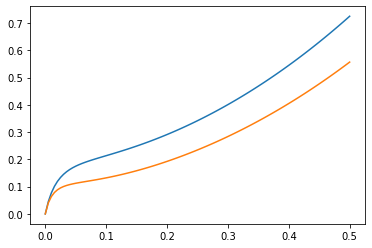

In [115]:
plt.plot(rateWnt,q[:,0])
plt.plot(rateWnt,q[:,1])